In [56]:
#run this everytime an edit is made in utils.py so that we can use the helper functions in this Python Notebook
import importlib
import utils_hw2
importlib.reload(utils_hw2)

<module 'utils_hw2' from '/Users/ivychan/finm-375-fixed-income-deriv-a/ivy-work/homework-2/utils_hw2.py'>

# Exercise - Stripping Caps


# 1. Pricing Floors


### Data

The file `data/cap_curves_2025-06-30.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.


In [57]:
#reading the data from Excel into a pandas Dataframe
import pandas as pd
import numpy as np

path = "data-hw2/cap_curves_2025-06-30.xlsx"
data = pd.read_excel(path)
data.head()

,tenor,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
0,0.25,0.042353,0.042353,0.989523,NaN,NaN,NaN
1,0.50,0.040859,0.040852,0.979883,0.039351,0.156842,0.156842
2,0.75,0.039391,0.039372,0.971043,0.036414,0.180709,0.201708
3,1.00,0.038115,0.038083,0.962807,0.034217,0.204576,0.240464
4,1.25,0.036704,0.036653,0.955417,0.030938,0.242127,0.328341


### 1.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency


In [58]:
NOTIONAL = 100.0
FREQUENCY = 0.25
T = 3.00
PAYMENT_DATE = T + FREQUENCY

strike3 = data.loc[data["tenor"] == T, "swap rates"].iloc[0]
fwd_rate3 = data.loc[data["tenor"] == PAYMENT_DATE, "forwards"].iloc[0]
discount3 = data.loc[data["tenor"] == PAYMENT_DATE, "discounts"].iloc[0]
fwd_vol3 = data.loc[data["tenor"] == T, "fwd vols"].iloc[0]
tau = T - FREQUENCY  #time to expiry = 2.75

floorlet_price3 = utils_hw2.black_price_floorlet(fwd_vol3, tau, strike3, fwd_rate3, discount3, NOTIONAL, FREQUENCY)

print(f"Price of floorlet (T=3) = {floorlet_price3:.6f}")

Price of floorlet (T=3) = 0.143422


### 1.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.


In [59]:
row_T = data.loc[data["tenor"] == T].iloc[0]
strikes = row_T["swap rates"]
fwd_vols = row_T["fwd vols"]

#payment dates: quarterly except first quarter
payment_dates = data["tenor"][(data["tenor"] >= 0.5) & (data["tenor"] <= T)]

rows = [{"maturity (T)": 0.25, "floorlet price": 0.00}] #we skip the first floorlet

for date in payment_dates:
    row = data.loc[data["tenor"] == date].iloc[0]

    fwd_rate = row["forwards"]
    discount_factor = row["discounts"]
    time_to_expiry = date - FREQUENCY

    price = utils_hw2.black_price_floorlet(fwd_vols, time_to_expiry, strikes, fwd_rate, discount_factor, NOTIONAL, FREQUENCY)

    rows.append({
        "maturity (T)": date,
        "floorlet price": price
    })

floorlet_summary = pd.DataFrame(rows)

floor_price = floorlet_summary["floorlet price"].sum()
floor_summary = pd.DataFrame({"floor price": [floor_price]})

display(floorlet_summary)
display(floor_summary)

,maturity (T),floorlet price
0,0.25,0.000000
1,0.50,0.007597
2,0.75,0.037137
3,1.00,0.070061
4,1.25,0.119634
5,1.50,0.136876
6,1.75,0.140716
7,2.00,0.142711
8,2.25,0.156880
9,2.50,0.148832


,floor price
0,1.24871


# 2. Stripping Caps


### Data

Continue with the file `data/cap_curves_2025-06-30.xlsx`.


### 2.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.


In [60]:
cap_maturities = data["tenor"][(data["tenor"] >= 0.5) & (data["tenor"] <= 10.0)]
strike = float(data.loc[np.isclose(data["tenor"], 10.0)].iloc[0]["swap rates"]) #fix one global ATM strike

cap_rows = []

for maturity in cap_maturities:
    row_T = data.loc[np.isclose(data["tenor"], maturity)].iloc[0]
    flat_vol = float(row_T["flat vols"]) #flat vol for the whole cap

    pay_dates = data["tenor"][(data["tenor"] >= 0.5) & (data["tenor"] <= maturity)].to_numpy()

    cap_pv = 0.0
    for pay_date in pay_dates:
        row_pay = data.loc[np.isclose(data["tenor"], pay_date)].iloc[0]
        fwd_rate = float(row_pay["forwards"]) #forward for [pay_date - Δ, pay_date]
        discount_factor = float(row_pay["discounts"]) #discount factor to payment date

        tau = float(pay_date) - FREQUENCY #option expiry

        cap_pv += utils_hw2.black_price_caplet(flat_vol, tau, strike, fwd_rate, discount_factor, NOTIONAL, FREQUENCY)

    cap_rows.append({
        "T": float(maturity),
        "cap_pv": cap_pv,
        "cap_pv_bps_of_notional": cap_pv / NOTIONAL * 10000
    })

cap_summary = pd.DataFrame(cap_rows).set_index("T")
display(cap_summary)

,cap_pv,cap_pv_bps_of_notional
T,,
0.50,0.079089,7.908939
0.75,0.127515,12.751502
1.00,0.174190,17.419035
1.25,0.228484,22.848406
1.50,0.292403,29.240341
1.75,0.367877,36.787703
2.00,0.451693,45.169308
2.25,0.529954,52.995356
2.50,0.618667,61.866713


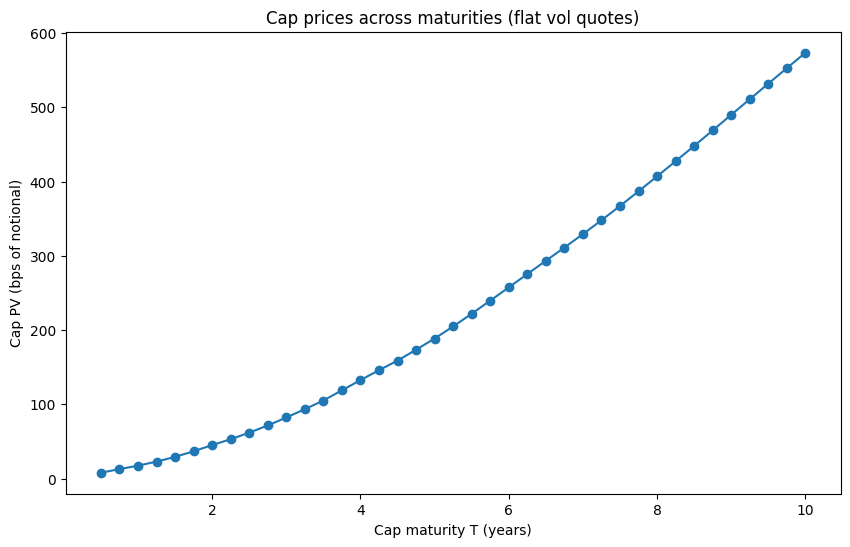

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
plt.plot(cap_summary.index, cap_summary["cap_pv_bps_of_notional"], marker = "o")
plt.xlabel("Cap maturity T (years)")
plt.ylabel("Cap PV (bps of notional)")
plt.title("Cap prices across maturities (flat vol quotes)")
plt.show()

### 2.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.


In [62]:
strike = float(data.loc[np.isclose(data["tenor"], 10.0)].iloc[0]["swap rates"]) #fix one global ATM strike (same as question 2.1)

#caplet at maturity T = Cap(T) - Cap(T - FREQUENCY)
caplet_rows = []

for maturity in cap_maturities:
    maturity = float(maturity)
    cap_pv_T = float(cap_summary.loc[maturity, "cap_pv"])

    prev_maturity = maturity - FREQUENCY #previous cap maturity

    if prev_maturity < 0.5: #first caplet: no previous cap to subtract
        caplet_pv = cap_pv_T
    else:
        cap_pv_prev = float(cap_summary.loc[prev_maturity, "cap_pv"])
        caplet_pv = cap_pv_T - cap_pv_prev

    row = data.loc[np.isclose(data["tenor"], maturity)].iloc[0]
    fwd_rate = float(row["forwards"])
    discount_factor = float(row["discounts"])
    flat_vol = float(row["flat vols"])
    tau = maturity - FREQUENCY #option expiry

    fwd_vol = utils_hw2.black_implied_vol_caplet(caplet_pv, tau, strike, fwd_rate, discount_factor, NOTIONAL, FREQUENCY)

    caplet_rows.append({
        "T": maturity,
        "caplet_pv": caplet_pv,
        "caplet_pv_bps_of_notional": caplet_pv / NOTIONAL * 10000,
        "fwd_vol": fwd_vol,
        "flat_vol": flat_vol
    })

caplet_summary = pd.DataFrame(caplet_rows).set_index("T")
display(caplet_summary)

,caplet_pv,caplet_pv_bps_of_notional,fwd_vol,flat_vol
T,,,,
0.50,0.079089,7.908939,0.156842,0.156842
0.75,0.048426,4.842563,0.192146,0.180709
1.00,0.046675,4.667533,0.237305,0.204576
1.25,0.054294,5.429371,0.335495,0.242127
1.50,0.063919,6.391935,0.351799,0.268642
1.75,0.075474,7.547362,0.349103,0.285885
2.00,0.083816,8.381605,0.336908,0.295615
2.25,0.078260,7.826048,0.319829,0.299596
2.50,0.088714,8.871357,0.299549,0.299589


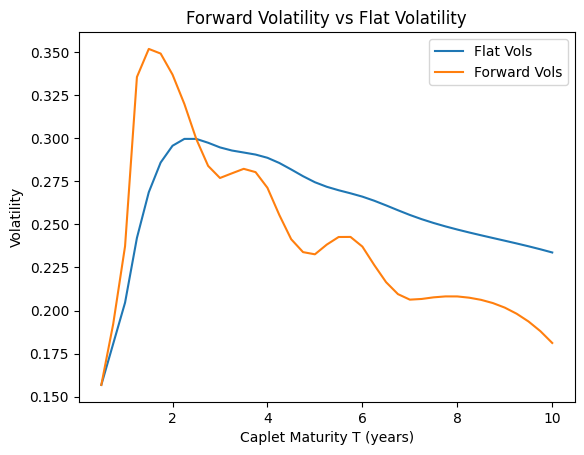

In [63]:
plt.figure()
plt.plot(caplet_summary.index, caplet_summary["flat_vol"], label = "Flat Vols")
plt.plot(caplet_summary.index, caplet_summary["fwd_vol"], label = "Forward Vols")
plt.xlabel("Caplet Maturity T (years)")
plt.ylabel("Volatility")
plt.title("Forward Volatility vs Flat Volatility")
plt.legend()
plt.show()